<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/pix2pixprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için

Bu çalışmada amaç elimizdeki düşük çözünürlüklü görüntüleri yüksek çözünürlükl hale getiren bir model oluşturmak istiyoruz.

In [4]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset

import os
import math
import numpy as np

from IPython.display import display

Burada aslında 500 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları düşük boyuta getirip sonrasında büyük boyutlu halleri ile eşleyerek yapay zeka eğitiminde kullancağız.

In [2]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archive.zip"


In [3]:
!unzip -q archive.zip

In [11]:
# Define paths
image_folder = "archive"  # Update with actual path
DOWNSCALE_FACTOR = 4  # Change this for different levels of downscaling

# Load images and create dataset
# Define a fixed target size (choose based on your dataset)
TARGET_SIZE = (256, 256)  # Adjust as needed

low_res_images, high_res_images = [], []


for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    # Load and resize high-res image
    high_res = img_to_array(load_img(img_path, target_size=TARGET_SIZE))

    # Create low-res image (downscale by factor of 4)
    low_res = cv2.resize(high_res, (TARGET_SIZE[0] // DOWNSCALE_FACTOR, TARGET_SIZE[1] // DOWNSCALE_FACTOR),
                          interpolation=cv2.INTER_CUBIC)

    # Store normalized versions
    high_res_images.append(high_res / 255.0)
    low_res_images.append(low_res / 255.0)

# Convert to NumPy arrays
high_res_images = np.array(high_res_images, dtype=np.float32)
low_res_images = np.array(low_res_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((low_res_images, high_res_images))
dataset = dataset.batch(16).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


Low Res Shape: (16, 64, 64, 3)
High Res Shape: (16, 256, 256, 3)


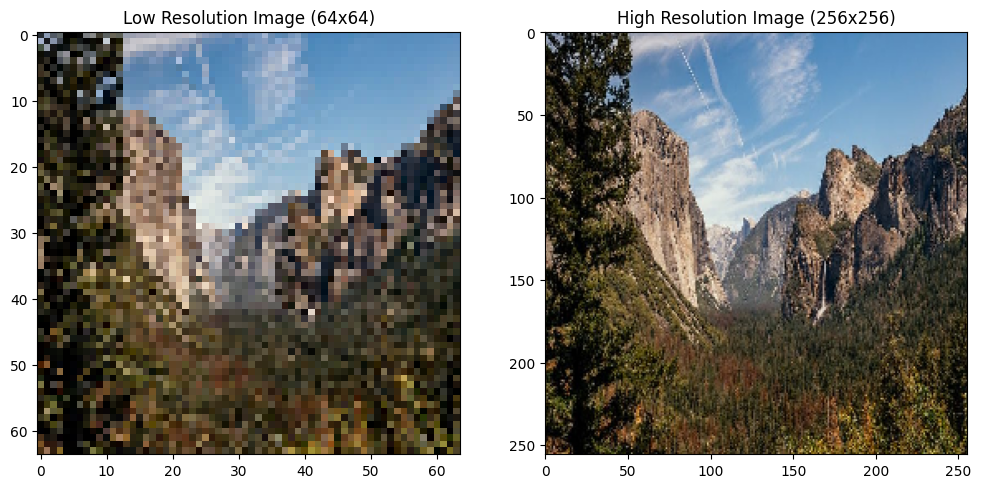

In [31]:
import matplotlib.pyplot as plt

# Let's visualize some images from the dataset
for low_res, high_res in dataset.take(3):  # Display 3 examples
    # low_res: shape (batch_size, 64, 64, 3)
    # high_res: shape (batch_size, 256, 256, 3)

    print("Low Res Shape:", low_res.shape)
    print("High Res Shape:", high_res.shape)

    # Plot the first image in the batch
    plt.figure(figsize=(12, 6))

    # Low resolution image
    plt.subplot(1, 2, 1)
    plt.imshow(low_res[0].numpy())  # Display first image in batch
    plt.title("Low Resolution Image (64x64)")

    # High resolution image
    plt.subplot(1, 2, 2)
    plt.imshow(high_res[0].numpy())  # Display first image in batch
    plt.title("High Resolution Image (256x256)")

    plt.show()
    break  # Only show 3 examples

In [32]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, LeakyReLU, Add, Input
from tensorflow.keras.models import Model

def build_upscaler():
    # Input layer (Low-resolution 64x64x3)
    inputs = Input(shape=(64, 64, 3))

    # Feature extraction block
    x = Conv2D(64, (9, 9), padding="same")(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (5, 5), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    # Upscaling and decoding blocks with skip connections
    x1 = UpSampling2D(size=(2, 2))(x)  # 64x64 → 128x128
    x1 = Conv2D(128, (5, 5), padding="same")(x1)
    x1 = LeakyReLU(alpha=0.2)(x1)
    x1 = BatchNormalization()(x1)

    x2 = UpSampling2D(size=(2, 2))(x1)  # 128x128 → 256x256
    x2 = Conv2D(64, (5, 5), padding="same")(x2)
    x2 = LeakyReLU(alpha=0.2)(x2)
    x2 = BatchNormalization()(x2)

    # Final layer to output 256x256 with 3 channels (RGB)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x2)

    # Create model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model

# Instantiate and summarize the model
model = build_upscaler()
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 64)          │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 128, 128, 128)       │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 256, 256, 64)        │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 256, 256, 3)         │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 841,475 (3.21 MB)

 Trainable params: 840,707 (3.21 MB)

 Non-trainable params: 768 (3.00 KB)

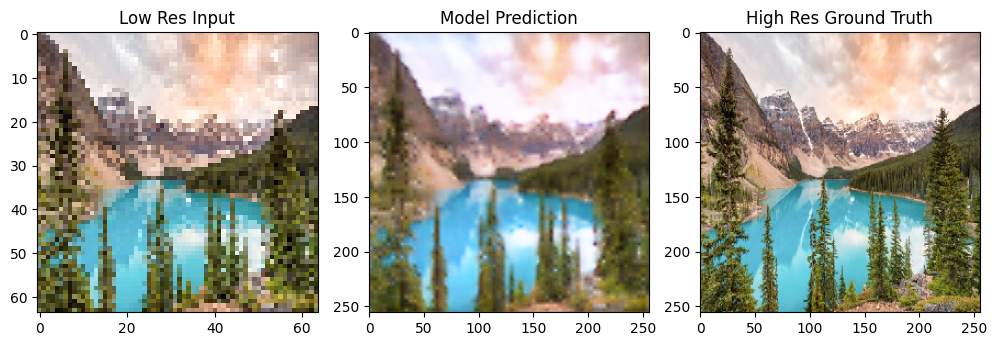

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 326ms/step - loss: 0.0092 - mae: 0.0642
Epoch 60/150
22/32 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 0.0075 - mae: 0.0584

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def on_epoch_end(self, epoch, logs=None):

        # early stop
        current_loss = logs.get('loss')

        # Check if the loss has improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If loss hasn't improved for 'patience' epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Get a sample of the validation data
        low_res, high_res = next(iter(self.val_data))

        # Ensure low_res and high_res have a batch dimension
        low_res = tf.expand_dims(low_res, axis=0) if len(low_res.shape) == 3 else low_res
        high_res = tf.expand_dims(high_res, axis=0) if len(high_res.shape) == 3 else high_res

        # Generate prediction from the model
        pred = self.model.predict(low_res)

        # Display images
        plt.figure(figsize=(10, 5))

        # Low-resolution input
        plt.subplot(1, 3, 1)
        plt.imshow(low_res[0])  # Show first image of batch
        plt.title("Low Res Input")

        # Model prediction
        plt.subplot(1, 3, 2)
        plt.imshow(pred[0])  # Show first predicted image
        plt.title("Model Prediction")

        # High-resolution ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(high_res[0])  # Show first high-res image
        plt.title("High Res Ground Truth")

        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

# Convert to tf.data.Dataset properly if it's not in batch form yet
val_data = tf.data.Dataset.from_tensor_slices((low_res_images[:10], high_res_images[:10]))  # Use 10 samples for validation
val_data = val_data.batch(1)  # Ensure the data is batched

# Add the callback to training
callback = DisplayPrediction(val_data)

# Train the model with the callback
model.fit(dataset, epochs=150, callbacks=[callback])


In [19]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


--2025-02-14 14:01:22--  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10730 (10K) [image/jpeg]
Saving to: ‘test1.jpg’

test1.jpg           100%[===================>]  10.48K  --.-KB/s    in 0s      

2025-02-14 14:01:22 (92.1 MB/s) - ‘test1.jpg’ saved [10730/10730]

--2025-02-14 14:01:22--  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response..

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (target_size[0] // downscale_factor, target_size[1] // downscale_factor),
                         interpolation=cv2.INTER_CUBIC)

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()

